In [1]:
from pyspark.sql import SparkSession

# Initialize Spark session with configurations
spark = SparkSession.builder.config("spark.app.name", "Data Investigation") \
                         .config("spark.executor.memory", "8g") \
                         .config("spark.executor.cores", "4") \
                         .config("spark.driver.memory", "4g") \
                         .config("spark.sql.shuffle.partitions", "200") \
                         .getOrCreate()

# Path to the CSV file in Google Cloud Storage
csv_path1 = "gs://msca-bdp-student-gcs/Group5/Steam_data/paid_data/part-00000-bd5f2055-83c5-471b-ba9c-1036cce464a9-c000.csv"
csv_path2 = "gs://msca-bdp-student-gcs/Group5/Steam_data/free_data/part-00000-cf669363-29bf-4c70-be25-878359d34cb3-c000.csv"

# Load the CSV file into a Spark DataFrame
df_p = spark.read.csv(csv_path1, header=True, inferSchema=True)
df_f = spark.read.csv(csv_path2, header=True, inferSchema=True)

In [2]:
from pyspark.sql import functions as F
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

#number of partitions
df_p.rdd.getNumPartitions()
# Repartition
df_p = df_p.repartition(20)
displaypartitions(df_p)

df_f.rdd.getNumPartitions()
# Repartition
df_f = df_f.repartition(3)
displaypartitions(df_f)

Partitions: 20


+-----------+-----+
|partitionId|count|
+-----------+-----+
|          3|  948|
|          5|  948|
|         16|  948|
|          4|  948|
|          0|  948|
|         18|  948|
|         17|  948|
|         15|  948|
|          2|  948|
|         19|  948|
|          1|  949|
|          7|  949|
|         12|  949|
|         14|  949|
|         10|  949|
|         13|  949|
|         11|  949|
|          6|  949|
|          9|  949|
|          8|  949|
+-----------+-----+

Partitions: 3
+-----------+-----+
|partitionId|count|
+-----------+-----+
|          0|  888|
|          1|  889|
|          2|  889|
+-----------+-----+



In [3]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Columns to encode
columns_to_encode = ["owners","tag","positive_range","review_category"]

# Initialize a list to store the stages of the pipeline
stages = []

# Process each column
for column in columns_to_encode:
    # StringIndexer: Convert categorical strings into numerical indices
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index", handleInvalid="skip")
    stages.append(indexer)
    
    # OneHotEncoder: Convert numerical indices into one-hot encoded vectors
    encoder = OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_encoded")
    stages.append(encoder)

# Create a pipeline with the stages
pipeline = Pipeline(stages=stages)

#Paid
# Fit the pipeline to the DataFrame and transform the data
encoded_df_p = pipeline.fit(df_p).transform(df_p)

# Select all columns from the original DataFrame and the newly encoded columns
df_p = encoded_df_p.select(*df_p.columns, *[f"{col}_encoded" for col in columns_to_encode])

#Free
# Fit the pipeline to the DataFrame and transform the data
encoded_df_f = pipeline.fit(df_f).transform(df_f)

# Select all columns from the original DataFrame and the newly encoded columns
df_f = encoded_df_f.select(*df_f.columns, *[f"{col}_encoded" for col in columns_to_encode])

# Split data set，Standerlize and Dimensionality reduction 

In [4]:
#Split data set
train_data_p, test_data_p = df_p.randomSplit([0.8, 0.2], seed=42)
train_data_f, test_data_f = df_f.randomSplit([0.8, 0.2], seed=42)

# Print counts to verify the split
print(f"Training Paid Data Count: {train_data_p.count()}")
print(f"Testing Paid Data Count: {test_data_p.count()}")

print(f"Training Paid Data Count: {train_data_f.count()}")
print(f"Testing Paid Data Count: {test_data_f.count()}")


24/12/01 21:15:32 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Training Paid Data Count: 15219


Testing Paid Data Count: 3751
Training Paid Data Count: 2162
Testing Paid Data Count: 504


#### Standardlize numerical data in both set

In [5]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Define the numerical columns to standardize
numerical_cols = [
    'positive', 'negative', 'average_forever', 'average_2weeks', 
    'median_forever', 'median_2weeks', 'price', 'initialprice', 
    'discount', "number_of_reviews", "positive_ratio"
]

# Assemble numerical columns into a single vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")

#Paid
train_assembled_p = assembler.transform(train_data_p)
test_assembled_p = assembler.transform(test_data_p)
#Free
train_assembled_f = assembler.transform(train_data_f)
test_assembled_f = assembler.transform(test_data_f)

# Fit the StandardScaler on the training set
#Paid
scaler_p = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withStd=True, withMean=True)
scaler_model_p = scaler_p.fit(train_assembled_p)
#Free
scaler_f = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withStd=True, withMean=True)
scaler_model_f = scaler_f.fit(train_assembled_f)

# Apply the scaler to both the training and testing sets
#Paid
train_scaled_p = scaler_model_p.transform(train_assembled_p)
test_scaled_p = scaler_model_p.transform(test_assembled_p)
#Free
train_scaled_f = scaler_model_f.transform(train_assembled_f)
test_scaled_f = scaler_model_f.transform(test_assembled_f)

from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

# Function to replace numerical columns with their standardized versions
def replace_with_scaled_features(scaled_data, numerical_columns):
    # Convert the scaled vector back to individual columns
    scaled_split = scaled_data.withColumn(
        "scaled_features_array", vector_to_array(col("scaled_numerical_features"))
    )

    # Replace the original numerical columns with standardized ones
    for i, col_name in enumerate(numerical_columns):
        scaled_split = scaled_split.withColumn(col_name, col("scaled_features_array")[i])

    # Drop the intermediate columns (vector column and array column)
    scaled_final = scaled_split.drop("numerical_features", "scaled_numerical_features", "scaled_features_array")
    
    return scaled_final

# Apply the function to both train and test sets
#Paid
train_scaled_final_p = replace_with_scaled_features(train_scaled_p, numerical_cols)
test_scaled_final_p = replace_with_scaled_features(test_scaled_p, numerical_cols)
#Free
train_scaled_final_f = replace_with_scaled_features(train_scaled_f, numerical_cols)
test_scaled_final_f = replace_with_scaled_features(test_scaled_f, numerical_cols)


In [6]:
# Step 4: Prepare for final feature assembly
encoded_cols = [f"{col}_encoded" for col in columns_to_encode]

# Flatten the categorical features list
all_columns = df_p.columns
categorical_features = list(set(all_columns) - set(numerical_cols) - {'name', 'appid', "owners", "tag", "positive_range", "review_category", 'ccu'})  # Previously encoded columns

# Combine standardized numerical features and categorical features
all_features = numerical_cols + categorical_features + encoded_cols

# Step 5: Create a VectorAssembler for all features
assembler_all = VectorAssembler(inputCols=all_features, outputCol="features")

# Apply the VectorAssembler to both training and testing sets
#Paid
train_final_p = assembler_all.transform(train_scaled_final_p)
test_final_p = assembler_all.transform(test_scaled_final_p)
#Free
train_final_f = assembler_all.transform(train_scaled_final_f)
test_final_f = assembler_all.transform(test_scaled_final_f)


# Select only the final features and target column
#Paid
train_final_p = train_final_p.select("features", "ccu")
test_final_p = test_final_p.select("features", "ccu")
#Free
train_final_f = train_final_f.select("features", "ccu")
test_final_f = test_final_f.select("features", "ccu")

# Print schema to verify
train_final_p.printSchema()
test_final_p.printSchema()
train_final_f.printSchema()
test_final_f.printSchema()


root
 |-- features: vector (nullable = true)
 |-- ccu: integer (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- ccu: integer (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- ccu: integer (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- ccu: integer (nullable = true)



In [7]:
train_final_p.head()

Row(features=SparseVector(107, {0: 7.6117, 1: 1.1951, 2: 7.052, 3: 0.0708, 4: 0.074, 5: 0.1412, 6: -0.1706, 7: -0.2715, 8: -0.4012, 9: 6.9705, 10: 1.1506, 15: 1.0, 17: 1.0, 29: 1.0, 33: 914.0, 35: 3454.0, 41: 1.0, 46: 4907.0, 49: 314.0, 50: 5480.0, 55: 1.0, 57: 629.0, 64: 1.0, 66: 1.0, 70: 3407.0, 73: 1.0, 79: 1.0, 90: 1.0, 95: 1.0, 102: 1.0, 106: 1.0}), ccu=14002)

In [8]:
test_final_p.head()

Row(features=SparseVector(107, {0: -0.1266, 1: -0.1128, 2: -0.0606, 3: -0.0407, 4: -0.0467, 5: -0.043, 6: -0.1706, 7: -0.2715, 8: -0.4012, 9: -0.1289, 10: 0.486, 17: 1.0, 22: 1.0, 38: 1.0, 52: 1.0, 57: 65.0, 59: 11.0, 72: 1.0, 83: 1.0, 92: 1.0, 99: 1.0, 105: 1.0}), ccu=21)

In [9]:
print(all_features)

['positive', 'negative', 'average_forever', 'average_2weeks', 'median_forever', 'median_2weeks', 'price', 'initialprice', 'discount', 'number_of_reviews', 'positive_ratio', 'tag_Exploration', 'tag_Funny', 'Ukrainian', 'score', 'German', 'tag_Casual', 'English', 'tag_Horror', 'Thai', 'owners_encoded', 'tag_Atmospheric', 'tag_Adventure', 'tag_PvP', 'tag_Indie', 'tag_Multiplayer', 'positive_range_encoded', 'tag_2D', 'tag_Fantasy', 'tag_FPS', 'Czech', 'Japanese', 'tag_Survival', 'tag_Action', 'Turkish', 'tag_encoded', 'tag_Strategy', 'Arabic', 'tag_Singleplayer', 'Dutch', 'Polish', 'Hungarian', 'Swedish', 'Korean', 'Russian', 'French', 'Danish', 'Norwegian', 'tag_Puzzle', 'tag_Shooter', 'tag_Simulation', 'review_category_encoded', 'tag_RPG', 'tag_3D', 'Finnish', 'recommendations', 'tag_Cute', 'Italian', 'tag_Sandbox', 'owners_encoded', 'tag_encoded', 'positive_range_encoded', 'review_category_encoded']


# Dimensional Reduction

24/12/01 21:15:51 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/12/01 21:15:51 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


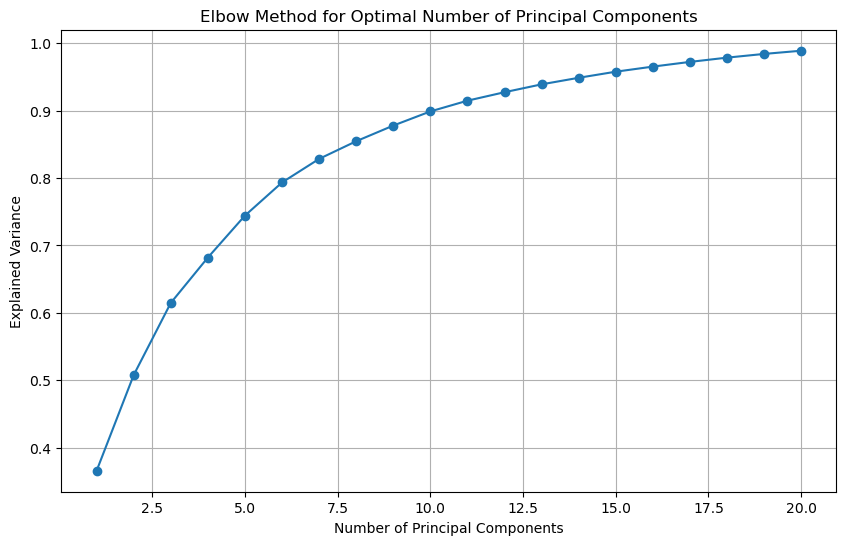

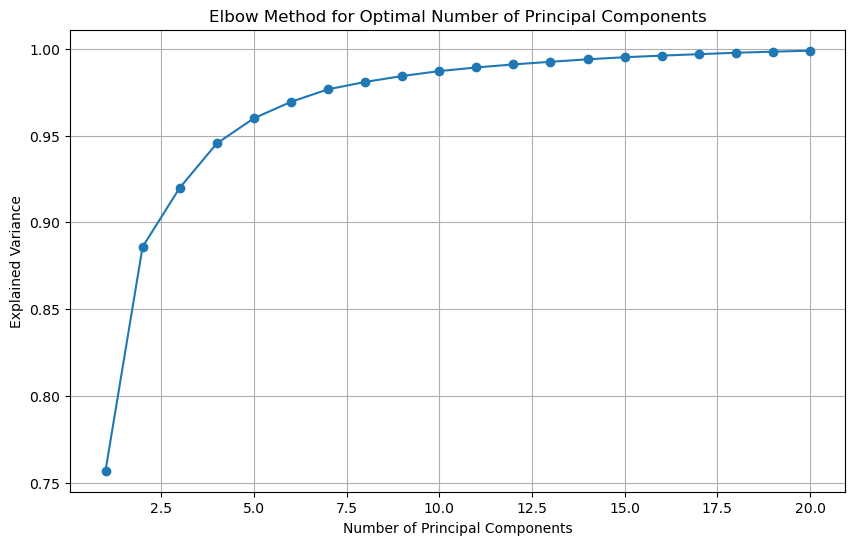

In [10]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt

# Function to determine the optimal number of principal components using the Elbow Method
def elbow_method(train_data, max_components=20):
    variance_explained = []
    for k in range(1, max_components + 1):
        pca = PCA(k=k, inputCol="features", outputCol="pca_features")
        pca_model = pca.fit(train_data)
        variance_explained.append(pca_model.explainedVariance.sum())
    
    # Plot the explained variance to identify the elbow point
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components + 1), variance_explained, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Explained Variance')
    plt.title('Elbow Method for Optimal Number of Principal Components')
    plt.grid(True)
    plt.show()

# Run the Elbow Method to determine the optimal number of components
#Paid
elbow_method(train_final_p)

#Free
elbow_method(train_final_f)


#### Therefore, according to graph, we choose 10 components (enought for explain 90% data) for paid data

In [11]:
# Set the number of principal components (e.g., reduce to 10 components)
num_components = 10

# Initialize PCA and set input and output column names
pca = PCA(k=num_components, inputCol="features", outputCol="pca_features")

# Fit the PCA model using the training data
pca_model = pca.fit(train_final_p)

# Transform both training and testing sets using the PCA model
train_pca_p = pca_model.transform(train_final_p)
test_pca_p = pca_model.transform(test_final_p)

# Select the reduced features and target column for both train and test datasets
train_reduced_p = train_pca_p.select("pca_features", "ccu")
test_reduced_p = test_pca_p.select("pca_features", "ccu")

# keep a duplicate of paid data for later model
train_reduced_n = train_reduced_p
test_reduced_n = test_reduced_p

# Print schema to verify
train_reduced_p.printSchema()
test_reduced_p.printSchema()

root
 |-- pca_features: vector (nullable = true)
 |-- ccu: integer (nullable = true)

root
 |-- pca_features: vector (nullable = true)
 |-- ccu: integer (nullable = true)



#### According to graph, we choose 3 components (enought for explain 90% data) for free data

In [12]:
# Set the number of principal components (e.g., reduce to 10 components)
num_components = 3

# Initialize PCA and set input and output column names
pca = PCA(k=num_components, inputCol="features", outputCol="pca_features")

# Fit the PCA model using the training data
pca_model = pca.fit(train_final_f)

# Transform both training and testing sets using the PCA model
train_pca_f = pca_model.transform(train_final_f)
test_pca_f = pca_model.transform(test_final_f)

# Select the reduced features and target column for both train and test datasets
train_reduced_f = train_pca_f.select("pca_features", "ccu")
test_reduced_f = test_pca_f.select("pca_features", "ccu")

# Print schema to verify
train_reduced_f.printSchema()
test_reduced_f.printSchema()

root
 |-- pca_features: vector (nullable = true)
 |-- ccu: integer (nullable = true)

root
 |-- pca_features: vector (nullable = true)
 |-- ccu: integer (nullable = true)



# Classification Model

In [13]:
# Print the range of 'ccu'
ccu_summary = train_reduced_p.selectExpr("min(ccu) as min_ccu", "max(ccu) as max_ccu").collect()[0]
print(f"Range of 'ccu' in paid training data: min = {ccu_summary['min_ccu']}, max = {ccu_summary['max_ccu']}")

ccu_summary = train_reduced_f.selectExpr("min(ccu) as min_ccu", "max(ccu) as max_ccu").collect()[0]
print(f"Range of 'ccu' in free training data: min = {ccu_summary['min_ccu']}, max = {ccu_summary['max_ccu']}")

Range of 'ccu' in paid training data: min = 0, max = 285216
Range of 'ccu' in free training data: min = 0, max = 574411


In [14]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when
#Convert 'ccu' into categories for classification
#Paid
train_reduced_p = train_reduced_p.withColumn(
    "ccu_category", 
    when(test_reduced_p["ccu"] < 500, "low")
    .when((test_reduced_p["ccu"] >= 500) & (test_reduced_p["ccu"] < 5000), "medium_low")
    .when((test_reduced_p["ccu"] >= 5000) & (test_reduced_p["ccu"] < 20000), "medium_high")
    .when((test_reduced_p["ccu"] >= 20000) & (test_reduced_p["ccu"] < 100000), "high")
    .otherwise("Very high")
)

test_reduced_p = test_reduced_p.withColumn(
    "ccu_category", 
    when(test_reduced_p["ccu"] < 500, "low")
    .when((test_reduced_p["ccu"] >= 500) & (test_reduced_p["ccu"] < 5000), "medium_low")
    .when((test_reduced_p["ccu"] >= 5000) & (test_reduced_p["ccu"] < 20000), "medium_high")
    .when((test_reduced_p["ccu"] >= 20000) & (test_reduced_p["ccu"] < 100000), "high")
    .otherwise("Very high")
)

#Free[Different standard]
train_reduced_f = train_reduced_f.withColumn(
    "ccu_category", 
    when(test_reduced_f["ccu"] < 500, "low")
    .when((test_reduced_f["ccu"] >= 500) & (test_reduced_f["ccu"] < 5000), "medium_low")
    .when((test_reduced_f["ccu"] >= 5000) & (test_reduced_f["ccu"] < 50000), "medium_high")
    .when((test_reduced_f["ccu"] >= 50000) & (test_reduced_f["ccu"] < 200000), "high")
    .otherwise("Very high")
)

test_reduced_f = test_reduced_f.withColumn(
    "ccu_category", 
    when(test_reduced_f["ccu"] < 500, "low")
    .when((test_reduced_f["ccu"] >= 500) & (test_reduced_f["ccu"] < 5000), "medium_low")
    .when((test_reduced_f["ccu"] >= 5000) & (test_reduced_f["ccu"] < 50000), "medium_high")
    .when((test_reduced_f["ccu"] >= 50000) & (test_reduced_f["ccu"] < 200000), "high")
    .otherwise("Very high")
)

# Use StringIndexer to convert categorical labels into numeric labels
#Paid
indexer_p = StringIndexer(inputCol="ccu_category", outputCol="ccu_category_index")
train_reduced_p = indexer_p.fit(train_reduced_p).transform(train_reduced_p)
test_reduced_p = indexer_p.fit(test_reduced_p).transform(test_reduced_p)
#Free
# Use StringIndexer to convert categorical labels into numeric labels
indexer_f = StringIndexer(inputCol="ccu_category", outputCol="ccu_category_index")
train_reduced_f = indexer_f.fit(train_reduced_f).transform(train_reduced_f)
test_reduced_f = indexer_f.fit(test_reduced_f).transform(test_reduced_f)

In [15]:
# Count the numeric labels for Paid training set
counts_paid_train=train_reduced_p.groupBy("ccu_category_index").count().show()

# Count the numeric labels for Paid test set
counts_paid_test=test_reduced_p.groupBy("ccu_category_index").count().show()

# Count the numeric labels for Free training set
counts_free_train=train_reduced_f.groupBy("ccu_category_index").count().show()

# Count the numeric labels for Free test set
counts_free_test=test_reduced_f.groupBy("ccu_category_index").count().show()


+------------------+-----+
|ccu_category_index|count|
+------------------+-----+
|               0.0|14746|
|               1.0|  371|
|               4.0|    3|
|               3.0|   28|
|               2.0|   71|
+------------------+-----+

+------------------+-----+
|ccu_category_index|count|
+------------------+-----+
|               0.0| 3647|
|               1.0|   80|
|               3.0|   10|
|               2.0|   14|
+------------------+-----+

+------------------+-----+
|ccu_category_index|count|
+------------------+-----+
|               0.0| 2046|
|               1.0|   91|
|               4.0|    2|
|               3.0|    3|
|               2.0|   20|
+------------------+-----+

+------------------+-----+
|ccu_category_index|count|
+------------------+-----+
|               0.0|  478|
|               1.0|   20|
|               4.0|    1|
|               3.0|    1|
|               2.0|    4|
+------------------+-----+



### Handle the inbalance

In [16]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
# Function to add weight column to handle imbalance
def add_weights(df: DataFrame, label_col: str, weight_col: str) -> DataFrame:
    class_count = df.groupBy(label_col).count().collect()
    total_count = sum(row['count'] for row in class_count)
    weights = {row[label_col]: total_count / row['count'] for row in class_count}
    
    weight_udf = udf(lambda x: float(weights[x]), DoubleType())
    
    df_weighted = df.withColumn(weight_col, weight_udf(df[label_col]))
    return df_weighted

train_reduced_p_weighted = add_weights(train_reduced_p, "ccu_category_index", "class_weight")
train_reduced_f_weighted = add_weights(train_reduced_f, "ccu_category_index", "class_weight")


### Model and Evaluation

In [17]:
# Prepare feature columns for RandomForest
# Paid
rf_classifier_p = RandomForestClassifier(labelCol="ccu_category_index", featuresCol="pca_features", weightCol="class_weight", numTrees=50)
rf_model_p = rf_classifier_p.fit(train_reduced_p_weighted)
predictions_p = rf_model_p.transform(train_reduced_p_weighted)

# Free
rf_classifier_f = RandomForestClassifier(labelCol="ccu_category_index", featuresCol="pca_features", weightCol="class_weight", numTrees=50)
rf_model_f = rf_classifier_f.fit(train_reduced_f_weighted)
predictions_f = rf_model_f.transform(train_reduced_f_weighted)

In [18]:
# Evaluate the models
# Paid
evaluator = MulticlassClassificationEvaluator(labelCol="ccu_category_index", predictionCol="prediction", metricName="accuracy")
accuracy_p = evaluator.evaluate(predictions_p)
print(f"Paid Model Accuracy: {accuracy_p:.5f}")

# Free
evaluator = MulticlassClassificationEvaluator(labelCol="ccu_category_index", predictionCol="prediction", metricName="accuracy")
accuracy_f = evaluator.evaluate(predictions_f)
print(f"Free Model Accuracy: {accuracy_f:.5f}")

Paid Model Accuracy: 0.81405
Free Model Accuracy: 0.76688


#### Very high accuracy, use cross validation to avoid overfitting

In [19]:
#Paid Data
# Perform manual cross-validation with training and validation accuracy tracking
num_folds = 10
train_metrics = []
validation_metrics = []

for i in range(num_folds):
    # Randomly split the data into training and test sets (80% training, 20% testing)
    train_data_cc, validation_data_cc = train_reduced_p_weighted.randomSplit([0.8, 0.2], seed=i)
    
    # Fit the model on the training data
    model = rf_classifier_p.fit(train_data_cc)
    
    # Make predictions on the training data
    train_predictions = model.transform(train_data_cc)
    # Make predictions on the validation data
    validation_predictions = model.transform(validation_data_cc)
    
    # Evaluate the model's accuracy on training data
    evaluator = MulticlassClassificationEvaluator(labelCol="ccu_category_index", predictionCol="prediction", metricName="accuracy")
    train_accuracy = evaluator.evaluate(train_predictions)
    train_metrics.append(train_accuracy)

    # Evaluate the model's accuracy on validation data
    validation_accuracy = evaluator.evaluate(validation_predictions)
    validation_metrics.append(validation_accuracy)
    
    print(f"Fold {i + 1}: Training Accuracy = {train_accuracy}, Validation Accuracy = {validation_accuracy}")

# Calculate the average accuracy across all folds
average_train_accuracy = sum(train_metrics) / len(train_metrics)
average_validation_accuracy = sum(validation_metrics) / len(validation_metrics)

print(f"Average Training Accuracy after {num_folds} folds: {average_train_accuracy}")
print(f"Average Validation Accuracy after {num_folds} folds: {average_validation_accuracy}")

# Compare training and validation performance
if average_train_accuracy > average_validation_accuracy + 0.05:
    print("Warning: Potential overfitting detected. The model performs significantly better on training data than on validation data.")
else:
    print("The model shows consistent performance across training and validation data.")


Fold 1: Training Accuracy = 0.8118354899859886, Validation Accuracy = 0.8156189241736876


Fold 2: Training Accuracy = 0.7846661170651278, Validation Accuracy = 0.78666235027517


Fold 3: Training Accuracy = 0.8014711959666088, Validation Accuracy = 0.8105769230769231


Fold 4: Training Accuracy = 0.7893167701863354, Validation Accuracy = 0.7881679389312977


Fold 5: Training Accuracy = 0.8216086633049516, Validation Accuracy = 0.8196668802049968


Fold 6: Training Accuracy = 0.8053674649050372, Validation Accuracy = 0.8115149565776777


Fold 7: Training Accuracy = 0.8074477747502271, Validation Accuracy = 0.8079150579150579


Fold 8: Training Accuracy = 0.8255459414915534, Validation Accuracy = 0.829118028534371


Fold 9: Training Accuracy = 0.7956962651496413, Validation Accuracy = 0.7996763754045307


Fold 10: Training Accuracy = 0.8236263283631271, Validation Accuracy = 0.8314935064935065
Average Training Accuracy after 10 folds: 0.8066582011168599
Average Validation Accuracy after 10 folds: 0.8100410941587217
The model shows consistent performance across training and validation data.


In [20]:
#Free Data
for i in range(num_folds):
    # Randomly split the data into training and test sets (80% training, 20% testing)
    train_data_cc, validation_data_cc = train_reduced_f_weighted.randomSplit([0.8, 0.2], seed=i)
    
    # Fit the model on the training data
    model = rf_classifier_f.fit(train_data_cc)
    
    # Make predictions on the training data
    train_predictions = model.transform(train_data_cc)
    # Make predictions on the validation data
    validation_predictions = model.transform(validation_data_cc)
    
    # Evaluate the model's accuracy on training data
    evaluator = MulticlassClassificationEvaluator(labelCol="ccu_category_index", predictionCol="prediction", metricName="accuracy")
    train_accuracy = evaluator.evaluate(train_predictions)
    train_metrics.append(train_accuracy)

    # Evaluate the model's accuracy on validation data
    validation_accuracy = evaluator.evaluate(validation_predictions)
    validation_metrics.append(validation_accuracy)
    
    print(f"Fold {i + 1}: Training Accuracy = {train_accuracy}, Validation Accuracy = {validation_accuracy}")

# Calculate the average accuracy across all folds
average_train_accuracy = sum(train_metrics) / len(train_metrics)
average_validation_accuracy = sum(validation_metrics) / len(validation_metrics)

print(f"Average Training Accuracy after {num_folds} folds: {average_train_accuracy}")
print(f"Average Validation Accuracy after {num_folds} folds: {average_validation_accuracy}")

# Compare training and validation performance
if average_train_accuracy > average_validation_accuracy + 0.05:
    print("Warning: Potential overfitting detected. The model performs significantly better on training data than on validation data.")
else:
    print("The model shows consistent performance across training and validation data.")


Fold 1: Training Accuracy = 0.7888953152111047, Validation Accuracy = 0.8036951501154734
Fold 2: Training Accuracy = 0.8017595307917889, Validation Accuracy = 0.7658643326039387
Fold 3: Training Accuracy = 0.7202838557066824, Validation Accuracy = 0.7197452229299363
Fold 4: Training Accuracy = 0.8341121495327103, Validation Accuracy = 0.8088888888888889
Fold 5: Training Accuracy = 0.743663594470046, Validation Accuracy = 0.7652582159624414
Fold 6: Training Accuracy = 0.736231884057971, Validation Accuracy = 0.7368421052631579
Fold 7: Training Accuracy = 0.7799882972498537, Validation Accuracy = 0.7858719646799117
Fold 8: Training Accuracy = 0.7360230547550433, Validation Accuracy = 0.7259953161592506
Fold 9: Training Accuracy = 0.8195402298850575, Validation Accuracy = 0.8104265402843602
Fold 10: Training Accuracy = 0.7334878331402086, Validation Accuracy = 0.731651376146789
Average Training Accuracy after 10 folds: 0.7880283877984533
Average Validation Accuracy after 10 folds: 0.78773

#### Visualized the result

In [21]:
#Paid Data
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import when
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np
import itertools

# Additional evaluation metrics - F1 Score
f1_p = MulticlassClassificationEvaluator(labelCol="ccu_category_index", predictionCol="prediction", metricName="f1").evaluate(predictions_p)
f1_f = MulticlassClassificationEvaluator(labelCol="ccu_category_index", predictionCol="prediction", metricName="f1").evaluate(predictions_f)

print(f"Paid Model F1 Score: {f1_p:.2f}")
print(f"Free Model F1 Score: {f1_f:.2f}")

# Generate Classification Report
# Convert predictions to Pandas DataFrame for sklearn usage
predictions_p_pd = predictions_p.select("ccu_category_index", "prediction").toPandas()
predictions_f_pd = predictions_f.select("ccu_category_index", "prediction").toPandas()

print("Paid Model Classification Report:")
print(classification_report(predictions_p_pd["ccu_category_index"], predictions_p_pd["prediction"]))

print("Free Model Classification Report:")
print(classification_report(predictions_f_pd["ccu_category_index"], predictions_f_pd["prediction"]))


Paid Model F1 Score: 0.88
Free Model F1 Score: 0.83


Paid Model Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90     14746
         1.0       0.10      0.70      0.17       371
         2.0       0.15      0.72      0.25        71
         3.0       0.48      0.89      0.62        28
         4.0       0.75      1.00      0.86         3

    accuracy                           0.81     15219
   macro avg       0.49      0.83      0.56     15219
weighted avg       0.97      0.81      0.88     15219

Free Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86      2046
         1.0       0.12      0.68      0.21        91
         2.0       0.29      0.70      0.41        20
         3.0       1.00      1.00      1.00         3
         4.0       1.00      1.00      1.00         2

    accuracy                           0.77      2162
   macro avg       0.68      0.83      0.70      2162
weighted 

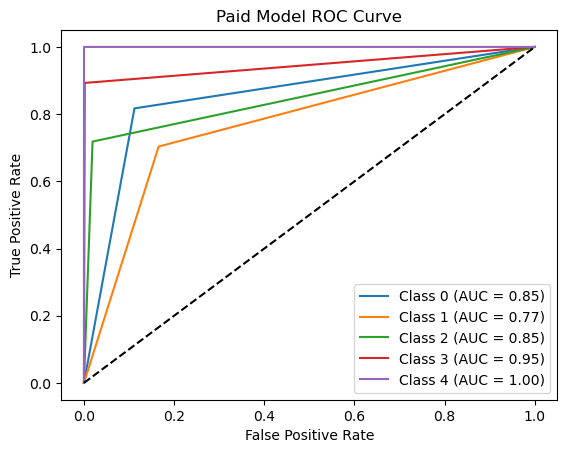

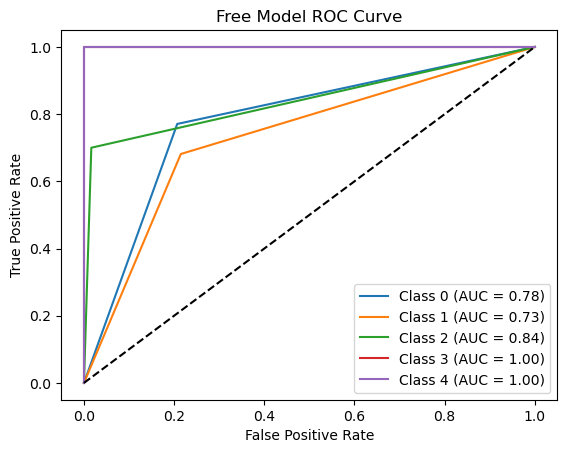

In [22]:
# Plot ROC Curve for each class
# Function to plot ROC curve
def plot_roc_curve(predictions_df, num_classes, title):
    plt.figure()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(predictions_df["ccu_category_index"].apply(lambda x: 1 if x == i else 0), predictions_df["prediction"].apply(lambda x: 1 if x == i else 0))
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Paid Model ROC Curve
num_classes_p = predictions_p_pd["ccu_category_index"].nunique()
plot_roc_curve(predictions_p_pd, num_classes_p, "Paid Model ROC Curve")

# Free Model ROC Curve
num_classes_f = predictions_f_pd["ccu_category_index"].nunique()
plot_roc_curve(predictions_f_pd, num_classes_f, "Free Model ROC Curve")


# Prediction Model_Paid Model

In [23]:
import numpy as np
# Convert the PySpark DataFrames to Pandas DataFrames
train_pd = train_reduced_n.toPandas()
test_pd = test_reduced_n.toPandas()

# Assuming the label column is named 'ccu'
X_train = np.array(train_pd.drop(columns=['ccu']).values.tolist())
y_train = train_pd['ccu'].values

X_test = np.array(test_pd.drop(columns=['ccu']).values.tolist())
y_test = test_pd['ccu'].values

# Reshape X_train and X_test to have the correct dimensions
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])


In [24]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.6/479.6 MB 25.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 114.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 132.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 101.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packa

In [25]:
!pip install keras-tuner

In [26]:
pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 135.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mgwr 2.2.1 requires spglm>=1.0.6, but you have spglm 0.0.0 which is incompatible.
momepy 0.0.0 requires shapely>=2, but you have shapely 1.8.2 which is incompatible.
pointpats 2.3.0 requires scipy>=1.8.0, but you have scipy 1.6.3 which is incompatible.
pysal 2.7.0 requires momepy>=0.5.3, but you have momepy 0.0.0 which is incompatibl

In [27]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 42.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 40.0 MB/s eta 0:00:0000:0100:01


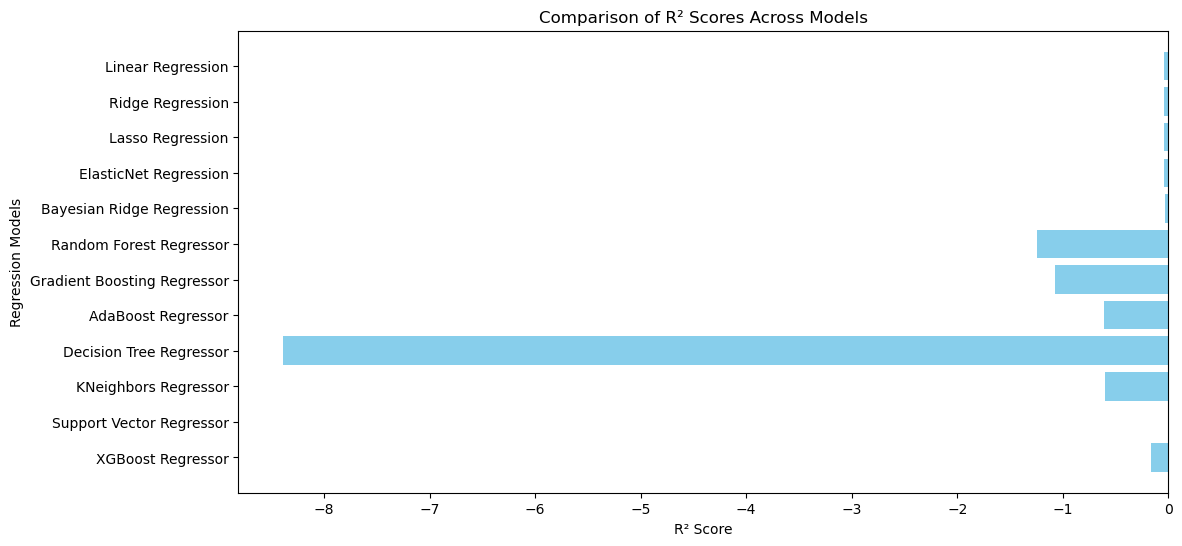

In [27]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# Define a list of regression models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Bayesian Ridge Regression": BayesianRidge(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost Regressor": AdaBoostRegressor(n_estimators=100, random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "KNeighbors Regressor": KNeighborsRegressor(n_neighbors=5),
    "Support Vector Regressor": SVR(kernel='rbf'),
    "XGBoost Regressor": xgb.XGBRegressor(objective='reg:squarederror',
                                            n_estimators=100,
                                            learning_rate=0.05,
                                            max_depth=6,
                                            subsample=0.8,
                                            colsample_bytree=0.8,
                                            random_state=42)
}

# Split the data for evaluation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Store R² scores in a dictionary for visualization
r2_scores = {}

# Evaluate each model and store the absolute R² score
for name, model in models.items():
    # Train the model
    model.fit(X_train_split, y_train_split)
    
    # Predict on the validation set
    y_pred = model.predict(X_val_split)
    
    # Calculate R² Score
    r2 = r2_score(y_val_split, y_pred)
    
    # Store the result
    r2_scores[name] = r2

# Convert results to lists for plotting
model_names = list(r2_scores.keys())
r2_values = list(r2_scores.values())

# Plot the R² scores
plt.figure(figsize=(12, 6))
plt.barh(model_names, r2_values, color="skyblue")
plt.xlabel("R² Score")
plt.ylabel("Regression Models")
plt.title("Comparison of R² Scores Across Models")
plt.gca().invert_yaxis()  # Invert y-axis to show the best model at the top
plt.show()

#### All model not work good, so we choose a neutral network model

### Hyper parameters Tunning for Neutral Newtwork

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner.tuners import RandomSearch
import numpy as np


# Define the Hypermodel
def build_model(hp):
    model = Sequential()

    # Input Layer + First Hidden Layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=128, max_value=512, step=64), 
        input_dim=X_train.shape[1], 
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.05)))

    # Additional Hidden Layers
    for i in range(hp.Int('num_layers', 2, 5)):  # You can add between 2 to 5 additional layers
        model.add(Dense(
            units=hp.Int(f'units_{i+2}', min_value=64, max_value=256, step=64),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.1, max_value=0.5, step=0.05)))

    # Output Layer
    model.add(Dense(1))  # Single output neuron for regression

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        ),
        loss='mse',
        metrics=['mae']
    )

    return model

# Set Up the Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_mae',  # Minimize validation MAE
    max_trials=20,  # Increase the number of different models to try
    executions_per_trial=3,  # Number of different runs with the same model
    directory='/tm',  # Directory where the results are saved
    project_name='neural_network_regression'
)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Search for the Best Hyperparameters
tuner.search(X_train, y_train,
             validation_split=0.2,
             epochs=150,
             batch_size=32,
             callbacks=[early_stop, reduce_lr],
             verbose=2)

# Get the Optimal Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first dense layer is {best_hps.get('units_1')}.
The optimal dropout rate for the first layer is {best_hps.get('dropout_1')}.
The number of additional layers is {best_hps.get('num_layers')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Trial 20 Complete [00h 02m 16s]
val_mae: 188.8815155029297

Best val_mae So Far: 180.8418935139974
Total elapsed time: 01h 26m 11s

The optimal number of units in the first dense layer is 192.
The optimal dropout rate for the first layer is 0.5.
The number of additional layers is 2.
The optimal learning rate for the optimizer is 0.00015298264388556446.



### Model and Cross validation

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner.tuners import RandomSearch
import numpy as np
from pyspark.ml.feature import VectorAssembler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold


def create_model(input_dim):
    """
    Function to create a neural network model.
    """
    model = Sequential()
    model.add(Dense(192, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Output layer
    
    # Compile the model
    optimizer = Adam(learning_rate=0.00015298264388556446)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model


In [15]:
def cross_validate_model(X, y, k_folds=10):
    """
    Perform k-fold cross-validation for the model and store the best R² and corresponding model.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Initialize lists to store metrics
    mae_scores = []
    r2_scores = []
    
    # Variables to store the best R² score and its corresponding model
    best_r2 = -np.inf  # Start with the lowest possible R²
    best_model = None
    
    fold = 1
    for train_index, val_index in kf.split(X):
        print(f"Starting Fold {fold}")
        
        # Split data into training and validation sets for this fold
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # Create a new model instance for each fold
        model = create_model(input_dim=X.shape[1])
        
        # Train the model on the training fold
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
        
        # Validate the model on the validation fold
        y_val_pred = model.predict(X_val_fold)
        
        # Calculate metrics
        mae = mean_absolute_error(y_val_fold, y_val_pred)
        r2 = r2_score(y_val_fold, y_val_pred)
        
        # Append metrics
        mae_scores.append(mae)
        r2_scores.append(r2)
        
        # Check if this fold has the best R²
        if r2 > best_r2:
            best_r2 = r2
            best_model = model  # Save the model with the best R²
        
        print(f"Fold {fold}: MAE = {mae}, R² = {r2}")
        fold += 1
    
    # Print average metrics
    print(f"Average MAE across {k_folds} folds: {np.mean(mae_scores)}")
    print(f"Average R² across {k_folds} folds: {np.mean(r2_scores)}")
    
    # Print the best R² score
    print(f"Best R² across all folds: {best_r2}")
    
    return best_model, best_r2


In [16]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Perform cross-validation and get the best model and R² score
best_model, best_r2 = cross_validate_model(X_train, y_train, k_folds=10)

# Print the best R²
print(f"Best R²: {best_r2}")

# Save the best model 
best_model.save("best_model.h5")


Starting Fold 1
48/48 [==============================] - 0s 2ms/step
Fold 1: MAE = 304.8519001177435, R² = -0.0010954383807606494
Starting Fold 2
48/48 [==============================] - 0s 1ms/step
Fold 2: MAE = 251.93365384025424, R² = 0.03636935940618358
Starting Fold 3
48/48 [==============================] - 0s 1ms/step
Fold 3: MAE = 377.5310168538081, R² = 0.1399727794344322
Starting Fold 4
48/48 [==============================] - 0s 1ms/step
Fold 4: MAE = 349.902720907495, R² = -0.5034355682816329
Starting Fold 5
48/48 [==============================] - 0s 1ms/step
Fold 5: MAE = 330.34889885348497, R² = 0.002399658764608348
Starting Fold 6
48/48 [==============================] - 0s 1ms/step
Fold 6: MAE = 232.1018964629449, R² = 0.1437100096116959
Starting Fold 7
48/48 [==============================] - 0s 1ms/step
Fold 7: MAE = 517.1702341062559, R² = -0.043766675273352984
Starting Fold 8
48/48 [==============================] - 0s 1ms/step
Fold 8: MAE = 239.9981449333738, R² =

/opt/conda/miniconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
from keras.models import load_model

# Load the model
loaded_model = load_model("best_model.h5")

# Use the loaded model for predictions
y_pred_loaded = loaded_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


118/118 [==============================] - 0s 1ms/step


Model Evaluation Metrics:
Mean Absolute Error (MAE): 237.94346735466874
Root Mean Squared Error (RMSE): 2375.85209391206
R² Score: 0.7879374354440986


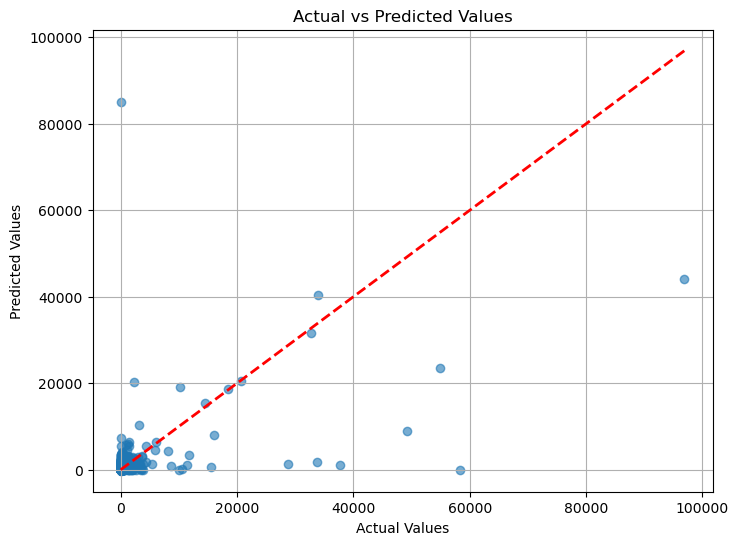

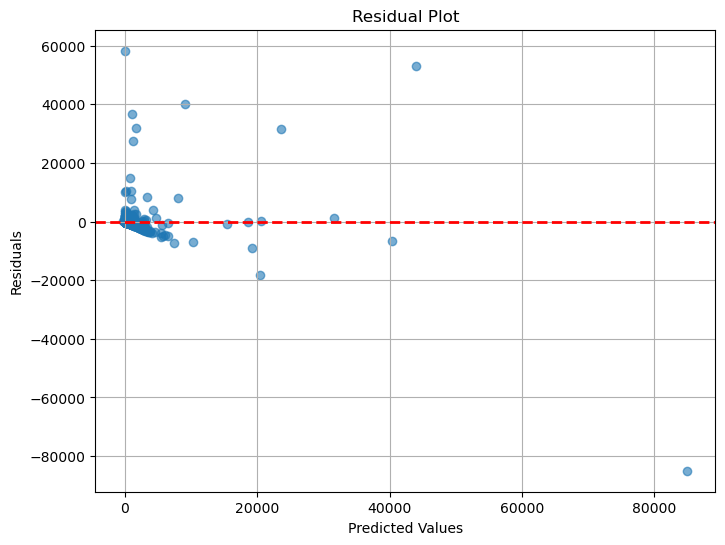

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Print evaluation metrics
print(f"Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): 237.94346735466874")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {best_r2}")

# Visualization 1: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Visualization 2: Residual Plot
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()
